# 1D CNN Hyperparameter Tuning
## Importing Libraries and Data

In [70]:
import pandas as pd
import numpy as np
from pandas import read_csv
import time
from pandas import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from prophet import Prophet 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch, Hyperband
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
df = read_csv('C:/Users/tomna/Desktop/Notebooks/Industrial Production of Electric and Gas Utilities/final_data.csv')
df.head()

,Observation_Date,Production_Index
0,01/01/1939,3.3335
1,01/02/1939,3.3590
2,01/03/1939,3.4353
3,01/04/1939,3.4607
4,01/05/1939,3.4607


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Observation_Date  1005 non-null   object 
 1   Production_Index  1005 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [72]:
# converting Time column to standard date/time format
df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%d/%m/%Y')  # m for month, M for min
df_prophet = df.copy()    # copy the dataframe for prediction analysis using prophet in the later sections
#display(df_prophet.head())   #  jupiter inbuilt function to print dataframe nicely
df = df.set_index('Observation_Date')
df = df.asfreq('MS', fill_value=np.nan)  # set the series frequency as month, starting at the first day of each month
df = df.sort_index()  # sort df by index in ascending order
df_DL = df.copy() # copy the dataframe for prediction analysis using deep learning approaches in the later sections
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [73]:
#verify that the series is complete, covering all time range
missing_times = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
if len(missing_times) == 0:
    print('The series is complete!')
else:
    print('The series is INCOMPLETE!! The following times are missing: ', missing_times)
    
# if (df.index == pd.date_range(start=df.index.min(), end=df.index.max(), freq=df.index.freq)).all() :  # all() or any() can be used
#     print('The series is complete!')
# else:
#     missing_times = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
#     print('The series is INCOMPLETE!! The following times are missing: ', missing_times)

The series is complete!


In [74]:
# check missing values for each column
df.isnull().sum()

Production_Index    0
dtype: int64

The prediction required is hourly demand of electricity but the current frequency is half an hour, so we convert the data to hourly frequency 

In [75]:
# cross checking the new frequency of the index if it is hourly
pd.infer_freq(df.index)

'MS'

## 1D CNN Tuning

In [76]:
# get the original dataframe with dates as index
df = df_DL
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [77]:
# converting the dataframe into a supervised series as per LSTM input shape format requirements
# first we define the function which converts df into a series of a historical data (X) defined by a window size (time steps) for predicting the next value (y) as per below example
    # [[[1], [2], [3], [4], [5]]] [6]
    # [[[2], [3], [4], [5], [6]]] [7]
    # [[[3], [4], [5], [6], [7]]] [8]
def create_supervised_series(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# set random seed
np.random.seed(7) # set the seed to ensure that our sample data in the train and test dataset will be the same every time we use the same seed number

In [78]:
#normalize the dataset
print('Shape before scaling: ', df.shape)
print('Min Max: ', df['Production_Index'].min(), ', ', df['Production_Index'].max())
df_as_np = df.values.astype('float32')  # ensure all values are in float, values returned as numpy array
scaler = MinMaxScaler(feature_range=(0, 1))
df_as_np = scaler.fit_transform(df_as_np)  # data is returned as numpy array
print('Shape after scaling: ', df_as_np.shape)
print('Min Max: ', df_as_np.min().round(5), ', ', df_as_np.max().round(5))

Shape before scaling:  (1005, 1)
Min Max:  3.3335 ,  126.5273
Shape after scaling:  (1005, 1)
Min Max:  0.0 ,  1.0


In [79]:
# splitting data into train and test datasets
train_size = int(len(df_as_np) * 0.8)  # assign 80% of data for training. The number should an integer to work in the next statement
df_train = df_as_np[0:train_size, :] # slicing numpy array - without iloc
df_test = df_as_np[train_size:len(df)+1, :]
print('Train & Test data size: ', len(df_train), ', ', len(df_test))
# reshape into X=t and y=t+1
look_back = 10
X_train, y_train = create_supervised_series(df_train, look_back)
X_test, y_test = create_supervised_series(df_test, look_back)
print('Train data shapes: ', X_train.shape, y_train.shape)
print('Test data shapes: ', X_test.shape, y_test.shape)

Train & Test data size:  804 ,  201
Train data shapes:  (793, 10) (793,)
Test data shapes:  (190, 10) (190,)


In [80]:
# reshape the input to be [samples, time steps, features]
# HERE we use a WINDOW based time series method. This approach uses previous lags (lookback) as unique input features processed at one time (timesteps=1)
timesteps = 1
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1])) # features=look_back
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)

X_train and X_test new shapes:  (793, 1, 10) ,  (190, 1, 10)


In [81]:
# # reshape the input to be [samples, time steps, features]
# # HERE we use a TIME STEP based time series method. This approach uses previous lags as a series of one input feature processed at different time steps
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # timesteps=X_train.shape[1]
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)

In [82]:
def build_CNN(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters_0',min_value=32,max_value=512,step=32,default=128),kernel_size=hp.Int('kernel_size_0',min_value=1,max_value=3,step=1),
            strides=1,padding='same', activation=hp.Choice('dense_activation_0',values=['relu', 'tanh', 'sigmoid'],default='relu'),
            kernel_initializer=hp.Choice('kernel_initializer_0',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
            input_shape=(timesteps, look_back))) # (samples, timesteps, features). It is not neccessary to assign samples regardless its size
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))  # default stride in pooling is 2 while in conv layer is 1
    model.add(Dropout(rate=hp.Choice('dropout_0',values=[0.1,0.2,0.3,0.4,0.5])))
    for i in range(hp.Int('layers', 1, 6)):  # evaluate the specified number of hidden layers 
        model.add(Conv1D(filters=hp.Int('filters_' + str(i),min_value=32,max_value=512,step=32,default=128),
                kernel_size=hp.Int('kernel_size_' + str(i),min_value=1,max_value=3,step=1),strides=1,padding='same',
                kernel_initializer=hp.Choice('kernel_initializer_' + str(i),values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
                activation=hp.Choice('dense_activation_' + str(i),values=['relu', 'tanh', 'sigmoid'])))
        model.add(MaxPooling1D(pool_size=2,strides=2,padding='same'))  # default stride in pooling is 2 while in conv layer is 1
        model.add(Dropout(rate=hp.Choice('dropout_' + str(i),values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(Flatten())
#     model.add(Dense(units=hp.Int('units_d1',min_value=32,max_value=512,step=32,default=128),activation=hp.Choice('dense_activation_d1',values=['relu', 'tanh', 'sigmoid'],default='relu'), kernel_initializer=hp.Choice('kernel_initializer_d1',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])))
#     model.add(Dropout(rate=hp.Choice('dropout_d1',values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(Dense(1))  
    optimizer = Adam(hp.Choice('learning_rate',values=[0.001,0.01,0.1,0.2,0.3,0.4,0.5]))
    model.compile(loss='mean_squared_error', optimizer=optimizer) 
    return model

In [83]:
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]  # set early stopping to prevent overfitting
tuner = Hyperband(build_CNN, objective='val_loss', max_epochs=20, directory='Time Series Forecasting',
                  project_name='CNN_Tuning', overwrite=True)
tuner.search(X_train, y_train, epochs=200, batch_size=30, validation_split=0.2, verbose=0, callbacks=stop_early)
tuner.results_summary()
best_params = tuner.get_best_hyperparameters()
print('Best Params: ', best_params[0].values)

INFO:tensorflow:Oracle triggered exit
Results summary
Results in Time Series Forecasting\CNN_Tuning
Showing 10 best trials
Trial summary
Hyperparameters:
filters_0: 384
kernel_size_0: 2
dense_activation_0: tanh
kernel_initializer_0: glorot_normal
dropout_0: 0.1
layers: 2
learning_rate: 0.001
filters_1: 256
kernel_size_1: 2
kernel_initializer_1: lecun_uniform
dense_activation_1: relu
dropout_1: 0.4
filters_2: 160
kernel_size_2: 3
kernel_initializer_2: glorot_uniform
dense_activation_2: tanh
dropout_2: 0.1
filters_3: 224
kernel_size_3: 3
kernel_initializer_3: he_normal
dense_activation_3: sigmoid
dropout_3: 0.5
filters_4: 352
kernel_size_4: 2
kernel_initializer_4: glorot_uniform
dense_activation_4: relu
dropout_4: 0.1
filters_5: 96
kernel_size_5: 2
kernel_initializer_5: normal
dense_activation_5: sigmoid
dropout_5: 0.1
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.001086625037714839
Trial summary
Hyperparameters:
filters_0: 384
kern

In [84]:
# get the best epoch between 1 and the specificied one using epochs variable
best_model = tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, epochs=200, validation_split=0.1, verbose=0)
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1  
print('\n Best epoch: ', best_epoch)
# rebuild the best model with the best epoch and evaluate using the test data
best_model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.1, verbose=0)
best_model.summary()


 Best epoch:  15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 384)            8064      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 384)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 384)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 384)            295296    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 384)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1,

In [85]:
# predicting train data
y_train_pred = best_model.predict(X_train, verbose=0)
# predicting test data
y_test_pred = best_model.predict(X_test, verbose=0)
# inverse actual data and predictions to their original scales
y_train = np.reshape(y_train, (y_train.shape[0], 1))  # changing the shape of the data to resamble with the predicted ones i.e from (1, y_train.shape[0]) to (y_train.shape[0], 1)
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
print()
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)
print('Train actuals and predictions shapes: ', y_train.shape, ', ', y_train_pred.shape)
print('Test actuals and predictions shapes: ', y_test.shape, ', ', y_test_pred.shape)


X_train and X_test new shapes:  (793, 1, 10) ,  (190, 1, 10)
Train actuals and predictions shapes:  (793, 1) ,  (793, 1)
Test actuals and predictions shapes:  (190, 1) ,  (190, 1)


In [89]:
# assessing model's performance in predicting test data
MAPE = round(mean_absolute_percentage_error(y_test, y_test_pred), 4)
MAE = round(mean_absolute_error(y_test, y_test_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  3.9000000804662704 % |  MAE:  4.018  |  RMSE:  4.97


In [90]:
# converting the test actuals and predictions to dataframe
y_test = y_test.flatten()
y_test_pred = y_test_pred.flatten()
df_test_results = pd.DataFrame({'Test Actuals':y_test, 'Test Predictions':y_test_pred}, index=df_DL.index[len(y_train):len(y_train)+len(y_test)]) 

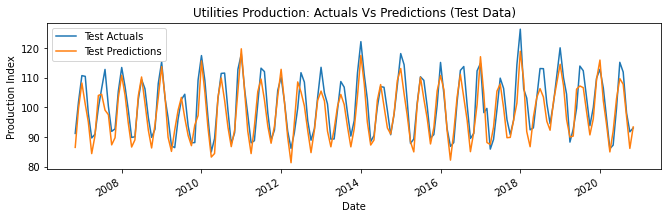

In [91]:
# plotting model's prediction on the test data
# we first shift the test data result to match its index with that of original data
df_test_results = df_test_results.shift(look_back*2 + 1)
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(df_test_results['Test Actuals'], label='Test Actuals')  # reduce the period of training data for image clarity
ax.plot(df_test_results['Test Predictions'], label='Test Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
#ax.set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=80, top =140)
ax.set_title('Utilities Production: Actuals Vs Predictions (Test Data)')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()